In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download("punkt")
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/god/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/god/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/Users/god/desktop/labeled.csv', sep=",")

In [3]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [4]:
# Замена flot на int в столбце toxic
df["toxic"] = df["toxic"].astype(int)

In [5]:
# Кол-во обычных комментариев и токсичных 
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [6]:
# Обзор негативных комментариев
for c in df[df["toxic"] == 1]["comment"].head(10):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)

Для каких стан является эталоном современная система здравоохранения РФ? Для Зимбабве? Ты тупой? хохлы

УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РАЗВОРУЮТ КАК ВСЕГДА! УЖЕ ТРЕЩИНАМИ ПОШ Л! ТУПЫЕ КИТАЗЫ НЕ МОГУТ НИЧЕГО НОРМАЛЬНО СДЕЛАТЬ!

Ебать тебя разносит, шизик.

Обосрался, сиди обтекай

Зачем ты пишешь хуйню, дегенерат? Поцелуй в губы ! поцелую в засос.



In [7]:
# Обзор не токсичных комментариев
for c in df[df["toxic"] == 0]["comment"].head():
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [8]:
# Разделение комментарий в качестве train и test для обучения модели 
train_df, test_df = train_test_split(df,test_size=1000)

In [9]:
# Обзор распределения test
test_df["toxic"].value_counts()

0    670
1    330
Name: toxic, dtype: int64

In [10]:
# Обзор распределения train
train_df["toxic"].value_counts()

0    8916
1    4496
Name: toxic, dtype: int64

Необходимо сделать из текста численные векторы для логистической регрессии

In [11]:
# Разбиение предложений на токены 
sentence_example = df.iloc[1]["comment"]                                    # Взятие одного комментария   
tokens = word_tokenize(sentence_example, language="russian")                # Вызов функции
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]           # Удаление пунктуации массивом string punctuation
russian_stop_words = stopwords.words("russian")                             # Получение стоп слов
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]    # Удаление стоп слов
snowball = SnowballStemmer(language="russian") 
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]    # Приведение к нижнему регистру, удаление окончаний 

In [12]:
print(f'Исходный текст: {sentence_example}')
print('________________________________________')
print(f'Токены: {tokens}')
print('________________________________________')
print(f'Токены без пунктуации: {tokens_without_punctuation}')
print('________________________________________')
print(f'Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}')
print('________________________________________')
print(f'Токены после стемминга: {stemmed_tokens}')

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

________________________________________
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
________________________________________
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
________________________________________
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
________________________________________
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'х

In [13]:
snowball = SnowballStemmer(language="russian")                     # Создание стэмера
russian_stop_words = stopwords.words("russian")                    # Создания списка стоп слов
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = "russian")         # Токенизация
    tokens = [i for i in tokens if i not in string.punctuation]    # Удаление пунктуации
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]                    # Стэминг
    return tokens

In [14]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

Массив токенов готов можно применять векторизацию 

In [15]:
# Создание Tfidf векторайзера замена токенайзера на мою созданный
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x, remove_stop_words=True))

Можно переходить к обучению векторайзера 
Создаем функцию fit_transform и передаем ей список из тренировачного датасэта

In [16]:
features = vectorizer.fit_transform(train_df["comment"])

Функция вернула фичи которые можно передавать в модель логистической регрессии 

In [17]:
model = LogisticRegression(random_state=0) # Создаю класс регрессии, random_state позволяет резултьтатам быть воспроизводимыми 
model.fit(features, train_df['toxic']) # В метод fit передаю фичи и разметку комментариев

LogisticRegression(random_state=0)

Модель обучилась на тренеровочном датасэте 
Прорерим результат 

In [18]:
# Результат классификации первого комментария - не токсичный 
model.predict(features[0])

array([0])

In [19]:
# Читаем этот комментарий 
train_df['comment'].iloc[0]

'Лично я почти никогда не прибегаю к рельсам, ибо их не любят игроки. Мне кажется их нужно использовать только в критических и или важных ситуациях.\n'

Теперь необходимо соединить векторайзер с моделью чтобы 
на вход модели подовать текст, а не вектора 

In [20]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)

In [21]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x127c8a160>)),
                ('model', LogisticRegression(random_state=0))])

In [22]:
# Модель определяет текст как не токсичный
model_pipeline.predict(["Проверим будет ли этот текст токсичным"])

array([0])

In [23]:
# Модель определяет текст как токсичный
model_pipeline.predict(["А не пойти ли тебе нафиг"])

array([1])

Следует измерить метрики precision, recall

In [24]:
precision_score(y_true=test_df["toxic"],\
                y_pred=model_pipeline.predict(test_df["comment"]))

0.889344262295082

In [25]:
recall_score(y_true=test_df["toxic"],\
                y_pred=model_pipeline.predict(test_df["comment"]))

0.6575757575757576

Precision меньше допустимого
Необходимо найти оптимальный thresholds

In [26]:
# Функция возращяет prec, rec, thresholds
prec, rec, thresholds = precision_recall_curve\
(y_true=test_df["toxic"],probas_pred\
=model_pipeline.predict_proba(test_df["comment"])[:,1])

/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


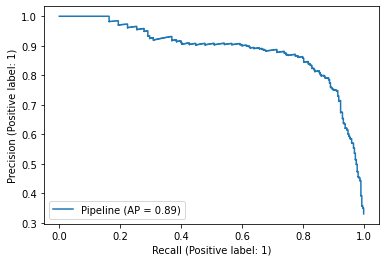

In [27]:
plot_precision_recall_curve(estimator=model_pipeline,\
X=test_df["comment"], y=test_df["toxic"])

In [28]:
np.where(prec > 0.95)

(array([898, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914,
        915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927,
        928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940,
        941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953,
        954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966,
        967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979,
        980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992,
        993, 994, 995, 996, 997, 998, 999]),)

In [29]:
thresholds[898]

0.7358469914710499

In [30]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[898])

0.95

In [31]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[898])

0.2878787878787879